# `AML — Task 2:` Heart rhythm classification from raw ECG signals.

---

In [1]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

## Dataset import and export

In [3]:
def load_from_csv():
    X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
    y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])
    X_test  = pd.read_csv('data/X_test.csv').drop(columns=['id'])
    return X_train, y_train, X_test

In [4]:
def export_to_csv(X_train, y_train, X_test):
    X_train.to_csv('data/X_train_cleaned.csv', index=False)
    y_train.to_csv('data/y_train_cleaned.csv', index=False)
    X_test.to_csv('data/X_test_cleaned.csv', index=False)

## Export `csv` submission file

In [5]:
def create_submission(sub_id, pred, basepath='submissions/task2-sub'):
    result = pred.copy().rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

## Data processing `TODO`

In [26]:
def series_to_heartbeats(time_series: pd.Series, sampling_rate=300.0) -> np.array:
    no_nans = time_series.dropna()
    rpeaks = ecg.engzee_segmenter(no_nans, sampling_rate)['rpeaks']
    beats, rpeaks = ecg.extract_heartbeats(no_nans, rpeaks, sampling_rate)
    beats = beats if len(beats.shape) == 2 else beats.reshape((1, -1))
    return beats, rpeaks

## Models defintion `TODO`

In [93]:
def best_svc(X_train, y_train):
    svc = SVC()
    gs_svc_params = {
        'kernel': ['rbf'], # ['rbf', poly', 'sigmoid']
        'C': [1.0] # np.logspace(0, 3, 6)
    }
    gs_svc = GridSearchCV(svc, gs_svc_params, cv=5, verbose=3, error_score='raise')
    gs_svc.fit(X_train, y_train)
    
    print(f"""The best validation score obtained is {gs_svc.best_score_:.5f} with
    \tkernel: {gs_svc.best_params_['kernel']}
    \tC: {gs_svc.best_params_['C']}""")
    
    return gs_svc

## Parameters tuning `TODO`

## Main pipeline

In [38]:
X_train_raw, y_train_raw, X_test_raw = load_from_csv()

<AxesSubplot:>

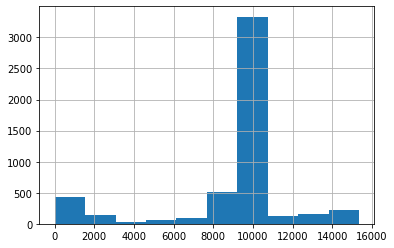

In [81]:
X_train_raw.isna().sum(axis='columns').hist()

<AxesSubplot:>

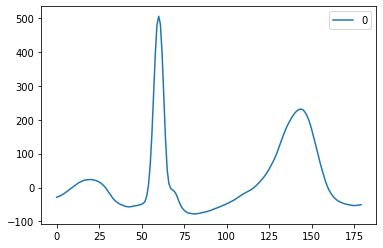

In [82]:
pd.DataFrame(np.mean(series_to_heartbeats(X_train_raw.iloc[0])[0], axis=0)).plot()

In [83]:
X_train = X_train_raw.apply(lambda r: pd.Series(np.mean(series_to_heartbeats(r)[0], axis=0)), axis=1)

In [96]:
X_test = X_test_raw.apply(lambda r: pd.Series(np.mean(series_to_heartbeats(r)[0], axis=0)), axis=1)

In [84]:
mask = X_train.isna().any(axis=1)

In [85]:
X_train[mask][:5]

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
X_train = X_train.dropna() # Q : Why do we have 19 NaN data samples ? Le summum de la comedia del arte
y_train = y_train_raw.loc[~mask]

In [94]:
svc = best_svc(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=1.0, kernel=rbf;, score=0.625 total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=1.0, kernel=rbf;, score=0.632 total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=1.0, kernel=rbf;, score=0.630 total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=1.0, kernel=rbf;, score=0.614 total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=1.0, kernel=rbf;, score=0.628 total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The best validation score obtained is 0.62613 with
    	kernel: rbf
    	C: 1.0


In [99]:
X_test[X_test.isna().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
a = [155, 172, 450, 509, 646, 704, 950, 970, 1040, 1147, 1740, 2223, 2267, 2304, 2501, 3169, 3381]

In [112]:
for i in a:
    X_test2.iloc[i] = np.ones(180)

In [113]:
X_test2[X_test2.isna().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179


## Generate new submission

In [95]:
model = svc # modify here

In [114]:
sub_id = 1
prediction = pd.DataFrame(model.predict(X_test2))

In [115]:
create_submission(sub_id, prediction)

**Solutions must be submitted on the [project website](https://aml.ise.inf.ethz.ch/task2/).**